In [194]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import requests
import json
import pandas as pd

# Import

In [195]:
lda = pd.read_csv("news_data/lda.csv")
tfidf = pd.read_csv("news_data/tfidf_snippet.csv")
sentiment = pd.read_csv("news_data/sentiment.csv")

In [196]:
columns_to_drop = ['headline.main', 'snippet', 'headline_lemmas', 'snippet_lemmas', 'Headline_Topic_0', 'Headline_Topic_1', 'Headline_Topic_2', 'Headline_Topic_3', 'Headline_Topic_4', 'Headline_Topic_5', 'Headline_Topic_6', 'Headline_Topic_7',	'Headline_Topic_8',	'Headline_Topic_9']
lda = lda.drop(columns=columns_to_drop)

In [197]:
columns_to_drop = ['headline.main', 'snippet', 'headline_lemmas', 'snippet_lemmas', 'headline_VADER', 'headline_AFINN']
sentiment = sentiment.drop(columns=columns_to_drop)

In [198]:
df = pd.merge(lda, tfidf, on='pub_date')
df = pd.merge(df, sentiment, on='pub_date')

In [199]:
df.rename(columns={'pub_date': 'Date'}, inplace=True)

In [200]:
# AAPL = pd.read_csv("stock_data/AAPL_stock.csv")
SP500 = pd.read_csv("stock_data/^GSPC_stock.csv")

In [201]:
# df = pd.merge(df, AAPL, on='Date')
df = pd.merge(df, SP500, on='Date')
df['Date'] = pd.to_datetime(df['Date'])

# Confounding

## CPI

In [202]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['CUUR0000SA0'], "startyear": "2016", "endyear": "2019"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
data_list = []
for series in json_data['Results']['series']:
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['period']
        value = item['value']
        footnotes = ""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            data_list.append([seriesId, year, period, value, footnotes[0:-1]])
cpi = pd.DataFrame(data_list, columns=["series id", "year", "period", "value", "footnotes"])

In [203]:
cpi['period'] = cpi['period'].str.replace('M', '')
cpi['datetime'] = pd.to_datetime(cpi['year'].astype(str) + cpi['period'].astype(str).str.zfill(2), format='%Y%m')
cpi = cpi.drop(['year', 'period'], axis=1)
cpi = cpi.drop(['footnotes','series id'], axis=1)
cpi = cpi.rename(columns={'value': 'CPI'})

In [204]:
df = pd.merge(df, cpi, left_on=df['Date'].dt.to_period('M'), right_on=cpi['datetime'].dt.to_period('M'), how='left')
df = df.drop(['key_0', 'datetime'], axis=1)

## Price

In [205]:
df = df.drop(['High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

# Train Test Split & Standardization

In [206]:
X = df.drop('Change', axis=1)  # X contains all columns except the target_column
y = df[['Date', 'Change']]  # y contains only the target_column
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [207]:
X['Date'] = pd.to_datetime(X['Date'])
y['Date'] = pd.to_datetime(y['Date'])
X_train = X[X["Date"].dt.year <= 2018]
X_test = X[X["Date"].dt.year == 2019]
y_train = y[y["Date"].dt.year <= 2018]
y_test = y[y["Date"].dt.year == 2019]
X_train.set_index('Date', inplace=True)
X_test.set_index('Date', inplace=True)
y_train.set_index('Date', inplace=True)
y_test.set_index('Date', inplace=True)

# Standardization vs. PCA

## PCA

In [208]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming you have X_train and X_test as your train and test feature sets
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
n_components = 2  # Set the number of components you want to keep
pca = PCA(n_components=n_components)

# Fit and transform the train data
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test data using the same PCA instance
X_test_pca = pca.transform(X_test_scaled)


## Standardization

In [209]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Linear Regression

## Standardized Data

In [210]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
"{:.2e}".format(mse)


'3.81e-03'

## PCA Data

In [211]:
model = LinearRegression()
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
"{:.2e}".format(mse)

'3.58e-05'

# Ridge Regression

## Standardized Data

In [212]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100], store_cv_values=True)
pipeline = make_pipeline(scaler, ridge_cv)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
best_alpha = ridge_cv.alpha_
print(f'Best alpha: {best_alpha}')
mse = mean_squared_error(y_test, y_pred)
"{:.2e}".format(mse)

Best alpha: 100.0


'8.88e-05'

## PCA Data

In [213]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


ridge_cv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100], store_cv_values=True)
pipeline = make_pipeline(scaler, ridge_cv)
pipeline.fit(X_train_pca, y_train)
y_pred = pipeline.predict(X_test_pca)
best_alpha = ridge_cv.alpha_
print(f'Best alpha: {best_alpha}')
mse = mean_squared_error(y_test, y_pred)
"{:.2e}".format(mse)

Best alpha: 100.0


'3.58e-05'

# Decision Tree

## Standardized Data

In [214]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
"{:.2e}".format(mse)

'8.94e-05'

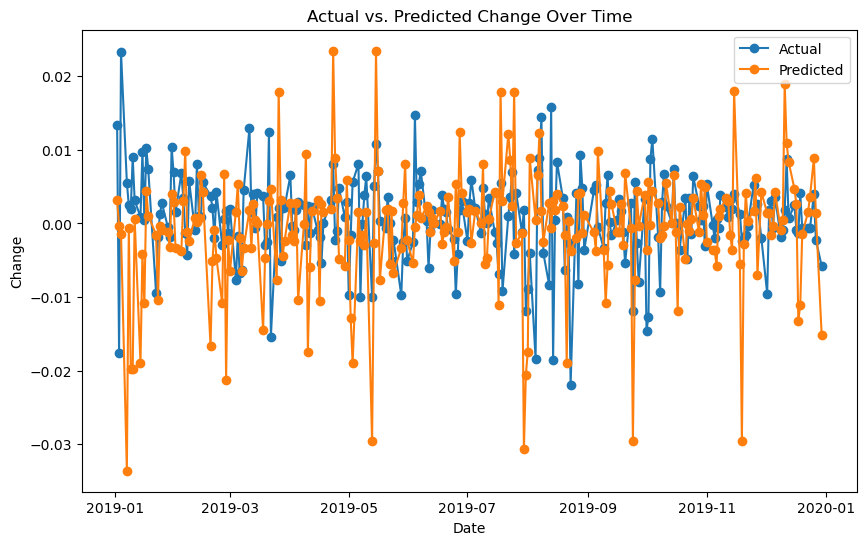

In [215]:
import matplotlib.pyplot as plt

# Assuming y_test is a DataFrame with 'Date' as the index and 'Change' as the column
# Replace 'Change' with the actual column name in your DataFrame
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test['Change'], label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='o')
plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Actual vs. Predicted Change Over Time')
plt.legend()
plt.show()

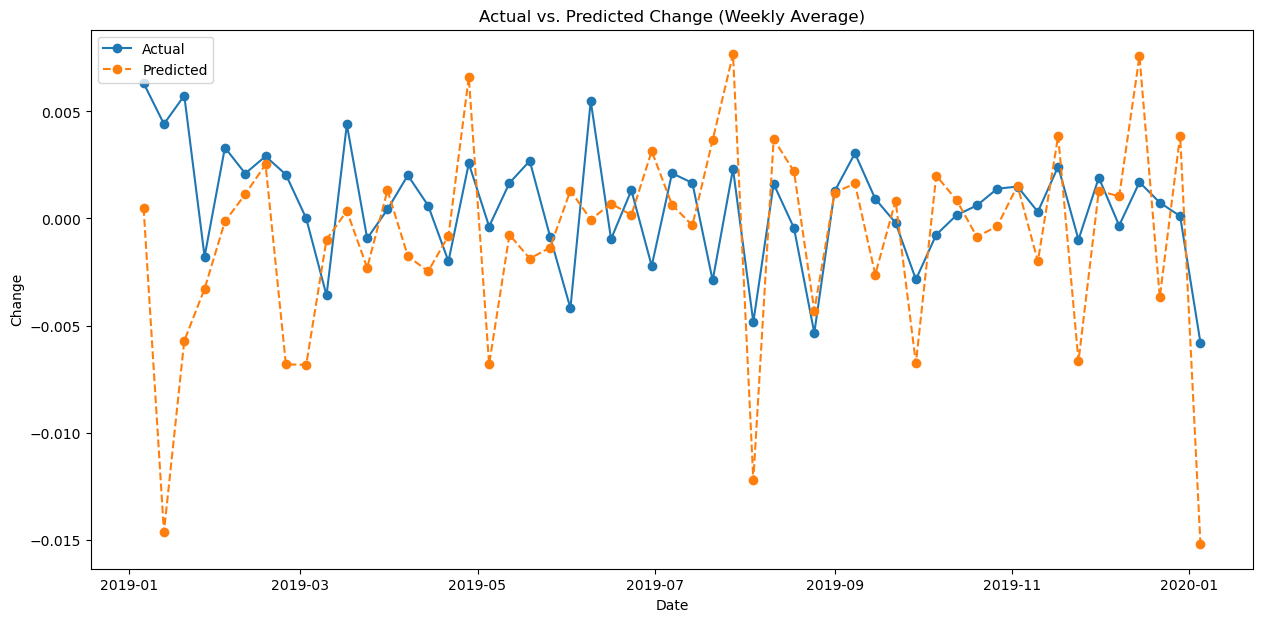

In [216]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_test and y_pred are properly indexed by date
# If y_pred is not a DataFrame, convert it to one with the same index as y_test
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['Predicted'])

# Resample to weekly averages
y_test_resampled = y_test.resample('W').mean()
y_pred_resampled = y_pred_df.resample('W').mean()

plt.figure(figsize=(15, 7))
plt.plot(y_test_resampled.index, y_test_resampled['Change'], label='Actual', marker='o', linestyle='-')
plt.plot(y_pred_resampled.index, y_pred_resampled['Predicted'], label='Predicted', marker='o', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Change')
plt.title('Actual vs. Predicted Change (Weekly Average)')
plt.legend()
plt.show()

## PCA Data

In [217]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_pca, y_train)
y_pred = tree_model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
"{:.2e}".format(mse)

'8.61e-05'

# Random Forest

## Standardized Data

In [218]:
from sklearn.ensemble import RandomForestRegressor


# Create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
"{:.2e}".format(mse)
# Feature importance
# feature_importance = rf_model.feature_importances_
# print("Feature Importance:", feature_importance)

'3.90e-05'

## PCA Data

In [219]:
from sklearn.ensemble import RandomForestRegressor


# Create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
"{:.2e}".format(mse)
# Feature importance
# feature_importance = rf_model.feature_importances_
# print("Feature Importance:", feature_importance)

'4.87e-05'

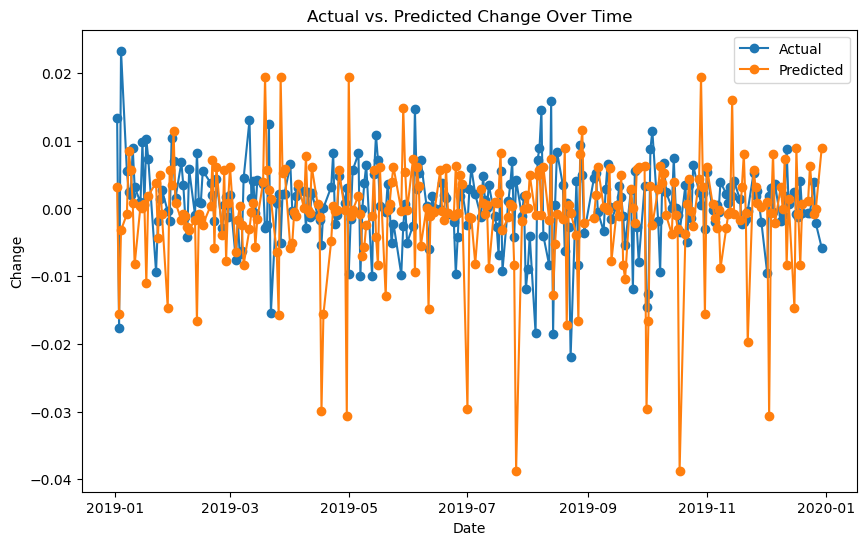

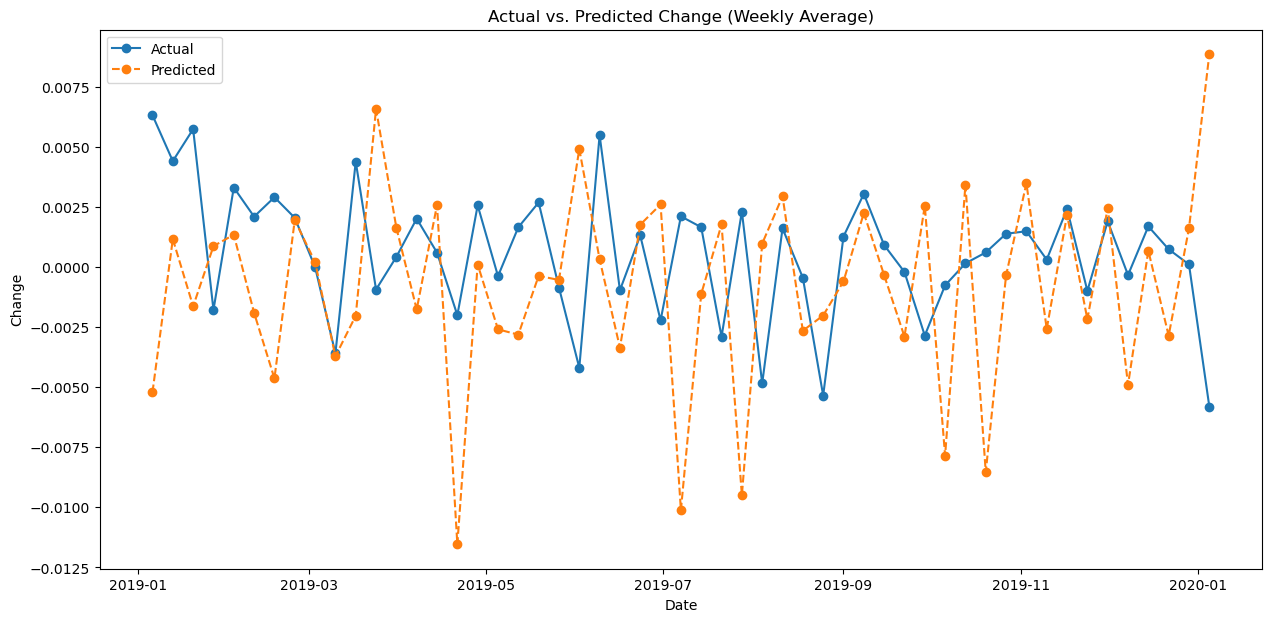

In [229]:
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Assuming sentiment_score_index is the index of the sentiment score in your features
sentiment_score_index = X.columns.get_loc("snippet_VADER")
alpha = 100  # Set this to the alpha you used in your Ridge model

# Bootstrap
n_bootstraps = 1000
coef_distributions = []

for i in range(n_bootstraps):
    # Resample the data with replacement
    X_resampled, y_resampled = resample(X_train, y_train)
    
    # Create a new Ridge model and fit the resampled data
    model = Ridge(alpha=alpha)
    model.fit(X_resampled, y_resampled)
    
    # Store the coefficient for sentiment
    coef_distributions.append(model.coef_[0,sentiment_score_index])

# Calculate the standard error and confidence intervals
coef_distributions = np.array(coef_distributions)
std_error = np.std(coef_distributions, ddof=1)
mean_coef = np.mean(coef_distributions)
confidence_interval = np.percentile(coef_distributions, [2.5, 97.5])

print(f"Mean Coefficient for Sentiment Score: {mean_coef}")
print(f"Standard Error: {std_error}")
print(f"95% Confidence Interval: {confidence_interval}")



Mean Coefficient for Sentiment Score: 0.0001785774280855697
Standard Error: 0.00015276605086161798
95% Confidence Interval: [-0.00010538  0.00048452]


In [239]:
import numpy as np
from sklearn.utils import resample
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Assuming sentiment_score_index is the index of the sentiment score in your features
sentiment_score_index = X.columns.get_loc("snippet_AFINN")
alpha = 100  # Set this to the alpha you used in your Ridge model

# Bootstrap
n_bootstraps = 1000
coef_distributions = []

for i in range(n_bootstraps):
    # Resample the data with replacement
    X_resampled, y_resampled = resample(X_train, y_train)
    
    # Create a new Ridge model and fit the resampled data
    model = Ridge(alpha=alpha)
    model.fit(X_resampled, y_resampled)
    
    # Store the coefficient for sentiment
    coef_distributions.append(model.coef_[0,sentiment_score_index])

# Calculate the standard error and confidence intervals
coef_distributions = np.array(coef_distributions)
std_error = np.std(coef_distributions, ddof=1)
mean_coef = np.mean(coef_distributions)
confidence_interval = np.percentile(coef_distributions, [2.5, 97.5])

print(f"Mean Coefficient for Sentiment Score: {mean_coef}")
print(f"Standard Error: {std_error}")
print(f"95% Confidence Interval: {confidence_interval}")

Mean Coefficient for Sentiment Score: -6.41923885355939e-05
Standard Error: 9.568273497911329e-05
95% Confidence Interval: [-0.00024997  0.00012162]



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0028  , p=0.9580  , df_denom=999, df_num=1
ssr based chi2 test:   chi2=0.0028  , p=0.9579  , df=1
likelihood ratio test: chi2=0.0028  , p=0.9579  , df=1
parameter F test:         F=0.0028  , p=0.9580  , df_denom=999, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0327  , p=0.9678  , df_denom=996, df_num=2
ssr based chi2 test:   chi2=0.0658  , p=0.9676  , df=2
likelihood ratio test: chi2=0.0658  , p=0.9676  , df=2
parameter F test:         F=0.0327  , p=0.9678  , df_denom=996, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2226  , p=0.8807  , df_denom=993, df_num=3
ssr based chi2 test:   chi2=0.6725  , p=0.8797  , df=3
likelihood ratio test: chi2=0.6722  , p=0.8797  , df=3
parameter F test:         F=0.2226  , p=0.8807  , df_denom=993, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1581  , p=0.9594  

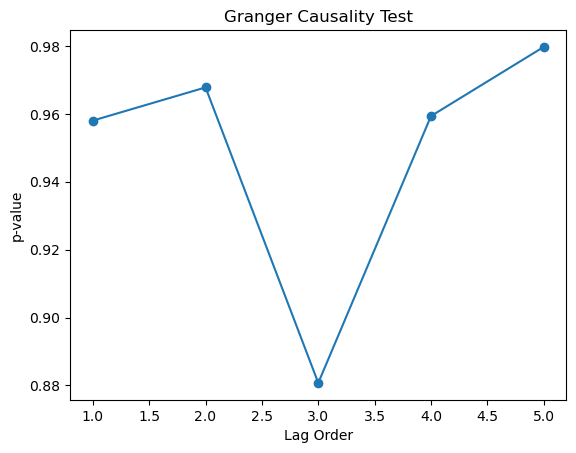

AttributeError: 'RollingRegressionResults' object has no attribute 'predict'

In [34]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt

# Assuming sentiment_df and stock_df have columns 'Date' and 'Score' for sentiment scores
# and 'Date' and 'Price' for stock prices, respectively.
# Make sure 'Date' is in datetime format.

# Merge the two DataFrames on the 'Date' column
merged_df = df[["snippet_VADER", "Change"]]

# Create lagged variables
merged_df['Lagged_Score'] = merged_df['snippet_VADER'].shift(1)
merged_df['Lagged_Price'] = merged_df['Change'].shift(1)

# Drop NaN values resulting from lagging
merged_df = merged_df.dropna()

# Perform Granger causality test
max_lag = 5  # Set the maximum lag for the test
granger_test_result = grangercausalitytests(merged_df[['Change', 'snippet_VADER']], max_lag, verbose=True)

# Extract p-values from the test results
p_values = [granger_test_result[i + 1][0]['ssr_ftest'][1] for i in range(max_lag)]

# Plot p-values
plt.plot(range(1, max_lag + 1), p_values, marker='o')
plt.title('Granger Causality Test')
plt.xlabel('Lag Order')
plt.ylabel('p-value')
plt.show()

# Choose a lag order based on the test results (e.g., the first lag with a p-value below a certain threshold)

# Build a predictive model using RollingOLS
endog = merged_df['Change']
exog = merged_df[['Lagged_Price', 'Lagged_Score']]

# Choose an appropriate window size for RollingOLS
window_size = 30
rolling_ols = RollingOLS(endog, exog, window=window_size)
rolling_res = rolling_ols.fit()

# Predictions on the test set
predictions = rolling_res.predict()

# Plot actual vs. predicted values
plt.plot(merged_df['Date'], endog, label='Actual Price')
plt.plot(merged_df['Date'], predictions, label='Predicted Price', linestyle='dashed')
plt.legend()
plt.title('Stock Price Prediction with Lagged Sentiment Scores')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
